In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk import Text
import collections
from keras.layers.core import Dense, SpatialDropout1D 
from keras.layers.convolutional import Conv1D 
from keras.layers.embeddings import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers import LSTM, Input
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences 
from keras.utils import np_utils
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))
# 어간추출도 동시에 진행
stemmer = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# dev, train, test data set 불러오기
with open("/content/drive/MyDrive/Python/friends_train.json") as json_file:
    json_train = json.load(json_file)
with open("/content/drive/MyDrive/Python/friends_test.json") as json_file:
    json_test = json.load(json_file)
with open("/content/drive/MyDrive/Python/friends_dev.json") as json_file:
    json_dev = json.load(json_file)

In [ ]:
def cleaning(str):
    replace_all = str
    eng_only = re.sub('[^a-zA-Z]', ' ', replace_all)
    # re.sub('패턴', '바꿀문자열', '문자열', 바꿀횟수)
    # [^a-zA-Z] :	두 % 문자 사이에 영문자가 없는 패턴
    no_capitals = eng_only.lower().split() # 소문자로 바꾸기
    #불용어제거하기
    no_stops = [word for word in no_capitals if not word in stops]
    stemmer_words = [stemmer.stem(word) for word in no_stops] 
    return ' '.join(stemmer_words)

In [ ]:
i = 0
train_data=[]
test_data=[]
for rows in json_train:
    for row in rows:
        train_data.append([cleaning(row['utterance']), row['emotion']])
for rows in json_dev:
    for row in rows:
        train_data.append([cleaning(row['utterance']), row['emotion']])
for rows in json_test:
    for row in rows:
        test_data.append([cleaning(row['utterance']), row['emotion']])

In [ ]:
count = 0
tagged = []
counter = collections.Counter()
for d in train_data:
    count = count + 1
    if count % 1000 == 0:
        print(count)
    words = pos_tag(word_tokenize(d[0]))
    for t in words:
        word = "/".join(t)
        tagged.append(word)
        counter[word] += 1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [ ]:
count = 0
tagged = []
counter = collections.Counter()
for d in test_data:
    count = count + 1
    if count % 1000 == 0:
        print(count)
    words = pos_tag(word_tokenize(d[0]))
    for t in words:
        word = "/".join(t)
        tagged.append(word)
        counter[word] += 1

1000
2000


In [ ]:
VOCAB_SIZE = 5000
word2_index = collections.defaultdict(int)
# enumerate 함수 사용하여 높은 빈도일 수록 낮은 인덱스 부여하기
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2_index[word[0]] = wid + 1
vocab_sz = len(word2_index) + 1
index2_word = {v:k for k, v in word2_index.items()}

In [ ]:
def labeltoint(str):
    return {'non-neutral': 0,
             'neutral': 1, 
             'joy': 2,
             'sadness': 3,
             'fear': 4,
             'anger': 5,
             'surprise': 6,
             'disgust': 7}[str]

xs, ys = [], []
count = 0
maxlen = 0
for d in train_data:
    count = count + 1
    ys.append(labeltoint(d[1]))
    if count % 1000 == 0:
        print(count)
    ang = pos_tag(word_tokenize(d[0]))
    words=[]
    for t in ang:
        words.append("/".join(t))
    if len(words) > maxlen: 
        maxlen = len(words)
    wids = [word2_index[word] for word in words]
    xs.append(wids)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [ ]:
xs_test, ys_test = [], []
count = 0
maxlen = 0
for d in test_data:
    count = count + 1
    ys_test.append(labeltoint(d[1]))
    if count % 1000 == 0:
        print(count)
    ang = pos_tag(word_tokenize(d[0]))
    words=[]
    for t in ang:
        words.append("/".join(t))
    if len(words) > maxlen: 
        maxlen = len(words)
    wids = [word2_index[word] for word in words]
    xs_test.append(wids)

1000
2000


In [ ]:
X_train = pad_sequences(xs, maxlen=maxlen) 
Y_train = np_utils.to_categorical(ys)
X_test = pad_sequences(xs_test, maxlen=maxlen) 
Y_test = np_utils.to_categorical(ys_test)

In [ ]:
EMBED_SIZE = 300 
NUM_FILTERS = 10 
NUM_WORDS = 3 
BATCH_SIZE = 512 
NUM_EPOCHS = 100

model = Sequential() 
model.add(Embedding(vocab_sz, EMBED_SIZE, input_length=maxlen)) 
model.add(SpatialDropout1D(0.5)) 
model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation="relu")) 
model.add(GlobalMaxPooling1D()) 
model.add(Dense(8, activation="softmax")) 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 24, 300)           843300    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 24, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 22, 10)            9010      
_________________________________________________________________
global_max_pooling1d (Global (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
Total params: 852,398
Trainable params: 852,398
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_en2.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]) 
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,callbacks=[es, mc], validation_split=0.2)

Epoch 1/100
19/19 [==============================] - 4s 148ms/step - loss: 2.0280 - accuracy: 0.2296 - val_loss: 1.9262 - val_accuracy: 0.4306
Epoch 2/100
19/19 [==============================] - 3s 138ms/step - loss: 1.8681 - accuracy: 0.4548 - val_loss: 1.8677 - val_accuracy: 0.4306
Epoch 3/100
19/19 [==============================] - 3s 132ms/step - loss: 1.7787 - accuracy: 0.4490 - val_loss: 1.8022 - val_accuracy: 0.4306
Epoch 4/100
19/19 [==============================] - 3s 137ms/step - loss: 1.7135 - accuracy: 0.4486 - val_loss: 1.7635 - val_accuracy: 0.4306
Epoch 5/100
19/19 [==============================] - 3s 133ms/step - loss: 1.6705 - accuracy: 0.4557 - val_loss: 1.7242 - val_accuracy: 0.4310
Epoch 6/100
19/19 [==============================] - 2s 119ms/step - loss: 1.6129 - accuracy: 0.4587 - val_loss: 1.6933 - val_accuracy: 0.4323
Epoch 7/100
19/19 [==============================] - 2s 116ms/step - loss: 1.5831 - accuracy: 0.4643 - val_loss: 1.6629 - val_accuracy: 0.4348

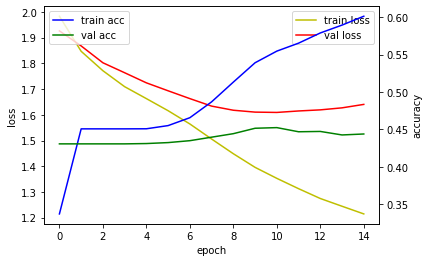

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=1)
print("Test score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

87/87 [==============================] - 0s 3ms/step - loss: 1.5819 - accuracy: 0.4595
Test score: 1.582, accuracy: 0.459


In [ ]:
def inttolabel(idx):
    return {0:'non-neutral',
             1:'neutral', 
             2:'joy',
             3:'sadness',
             4:'fear',
             5:'anger',
             6:'surprise',
             7:'disgust'}[idx]

def predict(text): 
    aa = pos_tag(word_tokenize(text))
    pp = []
    for t in aa:
        pp.append("/".join(t))
    wids = [word2_index[word] for word in pp]
    x_predict = pad_sequences([wids], maxlen=maxlen) 
    y_predict = model.predict(x_predict) 
    c = 0
    cnt = 0
    for y in y_predict[0]:
        if c < y:
            c = y
            ans = cnt
        cnt += 1
    ans = inttolabel(ans)
    return ans;

In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/Python/en_data.csv", sep=",", encoding="utf-8")
data.to_csv("/content/drive/MyDrive/Python/en_data.csv", sep=",", index=False)

In [ ]:
data['Expected'] = ''

In [ ]:
for i in range(0,len(data)):
  data.loc[i,'Expected'] = predict(data.loc[i,'utterance'])

In [ ]:
data['Expected'].value_counts()

neutral        1327
non-neutral     223
joy              37
surprise         36
Name: Expected, dtype: int64

In [ ]:
data.to_csv("/content/drive/MyDrive/Python/sample_eng_6.csv", sep=",", index=False)